In [36]:
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
%matplotlib inline

In [37]:
metadata_file = 'hee.csv'
df = pd.read_csv(metadata_file)
df.head()

,track,algorithm
0,3b81ca25f63af7ad1c4c641f8a18de48.wav,3
1,44e1d1532ff104c5f9b5edfb4c834917.wav,1
2,bee1d05f6e3890dbe17785638c5cbaae.wav,3
3,d3403c7f77326f7ec70d95cf8d2c7c3c.wav,4
4,6b43b6344a8929dd279bcf22d8349223.wav,2


In [38]:
df['algorithm'].value_counts()

0    1000
4    1000
1    1000
5    1000
2    1000
3    1000
Name: algorithm, dtype: int64

In [39]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [46]:
from os.path import exists

c=0

extracted_features=[]
for index_num,row in tqdm(df.iterrows()):
    final_class_labels=row["algorithm"]

    file_name = os.path.join('AugmentedData_Noise_Reverb/'+row["track"])
    if exists(file_name):
        c+=1
        data=features_extractor(file_name)
        extracted_features.append([data,final_class_labels])


    file_name_1 = os.path.join('AugmentedData_Noise_Reverb/'+row["track"][:-4]+'_noise.wav')
    if exists(file_name_1):
        c+=1
        data_1=features_extractor(file_name_1)
        extracted_features.append([data_1,final_class_labels])

    file_name_2 = os.path.join('AugmentedData_Noise_Reverb/'+row["track"][:-4]+'_reverb.wav')
    if exists(file_name_2):
        c+=1
        data_2=features_extractor(file_name_2)
        extracted_features.append([data_2,final_class_labels])

    file_name_3 = os.path.join('AugmentedData_Noise_Reverb/'+row["track"][:-4]+'_noise_reverb.wav')
    if exists(file_name_3):
        c+=1
        data_3=features_extractor(file_name_3)
        extracted_features.append([data_3,final_class_labels])

    file_name_4 = os.path.join('AugmentedData_Noise_Reverb/'+row["track"][:-4]+'_reverb_noise.wav')
    if exists(file_name_4):
        c+=1
        data_4=features_extractor(file_name_4)
        extracted_features.append([data_4,final_class_labels])
    #print(c)

6000it [29:34,  3.38it/s]


In [47]:
len(extracted_features)

30000

In [49]:
import random
random.shuffle(extracted_features)

In [60]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['track','algorithm'])
extracted_features_df.head(10)

,track,algorithm
0,"[-207.09058, 100.92251, -40.119305, 55.219852,...",1
1,"[-134.02742, 92.59171, -52.922974, 54.97019, -...",0
2,"[-237.76376, 127.441086, -31.227625, 61.401936...",5
3,"[-238.63606, 130.32304, -29.44698, 31.27427, -...",3
4,"[-245.32117, 125.14579, -33.47789, 22.448984, ...",3
5,"[-282.3576, 118.06943, -51.248043, 34.84502, -...",5
6,"[-194.77911, 94.16717, -45.942326, 56.24585, -...",0
7,"[-256.75424, 142.88445, -21.29943, 62.424458, ...",4
8,"[-123.5435, 94.86777, -56.789837, 64.12792, -4...",0
9,"[-201.3073, 122.8748, -22.252033, 63.46919, -2...",4


In [61]:
X=np.array(extracted_features_df['track'].tolist())
y=np.array(extracted_features_df['algorithm'].tolist())

In [62]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [64]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

###final layer
model.add(Dense(6))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               4100      
_________________________________________________________________
activation_8 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_9 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_10 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                

In [65]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [66]:
X_train.shape

(24000, 40)

In [67]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification_5.hdf5', verbose=1, save_best_only=True)  
#no num - first attempt with 6000 samples without truncating 40 mfcc - best / no dropout layers (22050)
#1 - 1s truncated 20 mfcc (16000) - no dropouts
#2 - 1s truncated with 22050Hz 40 mfcc - no dropouts
#3 - 6000 samples without truncating 40 mfcc with dropout layers (22050) 
#4 - noise with dropout
#5 - noise without dropout


start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
750/750 [==============================] - 1s 1ms/step - loss: 1.0435 - accuracy: 0.7101 - val_loss: 0.2800 - val_accuracy: 0.8935

Epoch 00001: val_loss improved from inf to 0.28000, saving model to saved_models\audio_classification_5.hdf5
Epoch 2/200
750/750 [==============================] - 1s 886us/step - loss: 0.2588 - accuracy: 0.9005 - val_loss: 0.2275 - val_accuracy: 0.9127

Epoch 00002: val_loss improved from 0.28000 to 0.22754, saving model to saved_models\audio_classification_5.hdf5
Epoch 3/200
750/750 [==============================] - 1s 882us/step - loss: 0.2349 - accuracy: 0.9107 - val_loss: 0.2972 - val_accuracy: 0.8865

Epoch 00003: val_loss did not improve from 0.22754
Epoch 4/200
750/750 [==============================] - 1s 905us/step - loss: 0.2169 - accuracy: 0.9147 - val_loss: 0.2056 - val_accuracy: 0.9258

Epoch 00004: val_loss improved from 0.22754 to 0.20558, saving model to saved_models\audio_classification_5.hdf5
Epoch 5/200
750/750 [===========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


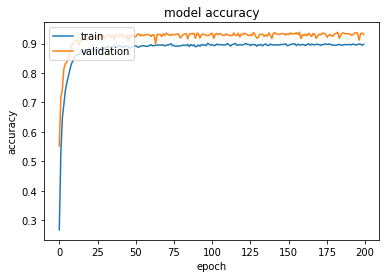

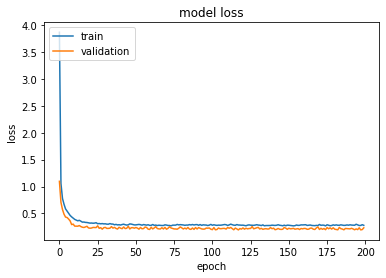

In [58]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


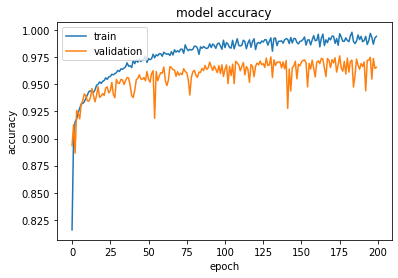

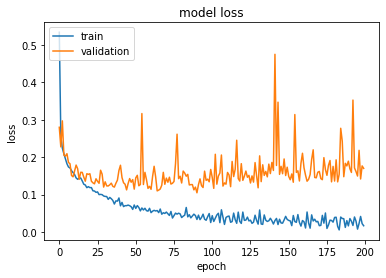

In [68]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()